__Author:__ Kevin Fan, revised: MN Evans, Feng Zhu, Lucie Luecke
<br>__Last edited:__ 2025/08/06 MNE
<br>__Modified from code by:__ Lucie Luecke

This notebook reads the DoD2k, filters for late 20th century speleothem $\delta^{18}O$ records, and uses CRUTS4.07 gridded temperature and precipitated amount-weighted mean annual $\delta^{18}O$ of precipitation estimated by Bowen and Ravenaugh (2003, updated) to simulate o18 of speleothem calcite and compare results across a spatial gradient, to observations.

Note that to execute this notebook, you will need to first download and unzip source input data from Harris et al (2020) and Bowen and Ravenough (2003, updated) in the directory speleothem_modeling_inputs.  See the Bibliography cell at bottom of this notebook and the file Quickstart.md for URLs and more information.

- v1.3: cleaned up (MNE)
- v1.4: added nearest non-NaN search for CRUTS and d18Op data (FZ)
- v1.4d: General cleaning of code and comments up to cell 21 (LL)
- v1.5: move to lluecke for github push, clean up, move gcd and nearest2d functions to functions.py, revise for key elements and debug
- v1.6: brief cleanup, updated plots (LL, MNE, KF); tested with simpler dod2k-env and relative paths

# Setup

In [1]:
## Import appropriate libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import scipy
import scipy.io as sio
#import rasterio as rs #previous version was 1.3.5
import rasterio.features
from rasterio import transform
from rasterio.plot import show
#import pyproj
from psm import speleo
import netCDF4
import sklearn 
from sklearn.neighbors import NearestNeighbors
import rioxarray
import xarray as xr
from tqdm import tqdm
import cfr
import psm

import functions as f # utility functions

In [2]:
# Set the default working directory (parent folder of the database and helper files); change into it
wdir = os.curdir
os.chdir(wdir)

# Display the working directory
print('working directory: '+wdir)

working directory: .


# Reading and filtering data

## Load DoD2k

In [3]:
# Read data from database of databases pickle file
read_df    = pd.read_pickle('./dod2k_dupfree_dupfree/dod2k_dupfree_dupfree_compact.pkl') 


In [4]:
# Filter for desired data, in this case, speleothem calcite oxygen isotope measurements from the years min_year to max_year
filtered_df = read_df.loc[(read_df["paleoData_proxy"] =="d18O") & (read_df["archiveType"] == "speleothem") & (read_df["paleoData_notes"] == "calcite")]
# archiveType filters for speleothem data - LL: includes only d18O speleothem type proxies

# Filter data for time series that include records from or past the year 1960 AD
min_year = 1960 # Inclusive
max_year = 2006 # Exclusive

# d18O data ranges from 1960 to 2005- pick data to match the same timeframe
filtered_df = filtered_df.loc[read_df["year"].apply(lambda x: np.max(x) >= min_year and np.min(x) < max_year)] #exclude post 2005 data
filtered_df.reset_index(inplace = True)

# Filter the filtered records for data in the correct timeframe
new_year = []
new_values = []
# For every row, apply above time conditions
for i in range (0, len(filtered_df)):
    index = np.where(filtered_df.iloc[i]["year"] >= min_year)
    new_year.append(filtered_df.iloc[i]["year"][index]) # Adds values to lists
    new_values.append(filtered_df.iloc[i]["paleoData_values"][index])
filtered_df["year"] = new_year # Create a dataframe with the filtered data lists populating it
filtered_df["paleoData_values"] = new_values
filtered_df.head()

,index,climateInterpretation_variable,climateInterpretation_variableDetail,dataSetName,datasetId,duplicateDetails,geo_meanElev,geo_meanLat,geo_meanLon,geo_siteName,originalDataURL,originalDatabase,paleoData_notes,paleoData_proxy,paleoData_sensorSpecies,paleoData_units,paleoData_values,year,yearUnits,archiveType
0,4018,temperature+moisture,temperature+moisture - manually assigned by Do...,Leviathan cave,sisal_124.0_80,N/A,2400.0,37.889999,-115.580002,Leviathan cave,10.1038/ncomms4805,SISAL v3,calcite,d18O,N/A,permil,"[-10.80075, -11.489776]","[2010.0, 1960.0]",CE,speleothem
1,4029,temperature+moisture,temperature+moisture - manually assigned by Do...,Soylegrotta cave,sisal_137.0_92,N/A,280.0,66.000000,14.000000,Soylegrotta cave,10.1016/s0031-0182(00)00225-x,SISAL v3,calcite,d18O,N/A,permil,"[-6.545692, -6.687666]","[1967.0, 1993.0]",CE,speleothem
2,4038,temperature+moisture,temperature+moisture - manually assigned by Do...,Wah Shikhar cave,sisal_148.0_103,N/A,1290.0,25.250000,91.866699,Wah Shikhar cave,10.1029/2011gl047713,SISAL v3,calcite,d18O,N/A,permil,"[-5.456, -5.131, -5.207, -5.231, -5.512, -5.22...","[2006.6533, 2005.3066, 2003.96, 2002.6132, 200...",CE,speleothem
3,4047,temperature+moisture,temperature+moisture - manually assigned by Do...,Macal Chasm,sisal_178.0_112,N/A,530.0,16.882999,-89.108002,Macal Chasm,10.1016/j.palaeo.2016.07.007,SISAL v3,calcite,d18O,N/A,permil,"[-3.8, -4.0, -4.4, -4.1]","[1992.6, 1982.5, 1972.8, 1962.9]",CE,speleothem
4,4050,temperature+moisture,temperature+moisture - manually assigned by Do...,Anjohibe,sisal_187.0_115,N/A,131.0,-15.530000,46.880001,Anjohibe,10.1016/j.quascirev.2016.01.007,SISAL v3,calcite,d18O,N/A,permil,"[-5.4101586, -5.056273, -5.6141157, -5.6299877...","[2014.0, 2004.5264, 1995.0526, 1985.579, 1976....",CE,speleothem


In [5]:
#%% check data extraction for proxy_type and archive_type
proxy_types   = filtered_df['paleoData_proxy'].unique()
archive_types = filtered_df['archiveType'].unique()
calcite_types = filtered_df['paleoData_notes'].unique()

print('Proxy type: ', proxy_types)
print('Archive type: ', archive_types)
print('Carbonate type: ', calcite_types)
# should give only ['d18O'], ['speleothem'], ['calcite']

Proxy type:  ['d18O']
Archive type:  ['speleothem']
Carbonate type:  ['calcite']


### Plot data

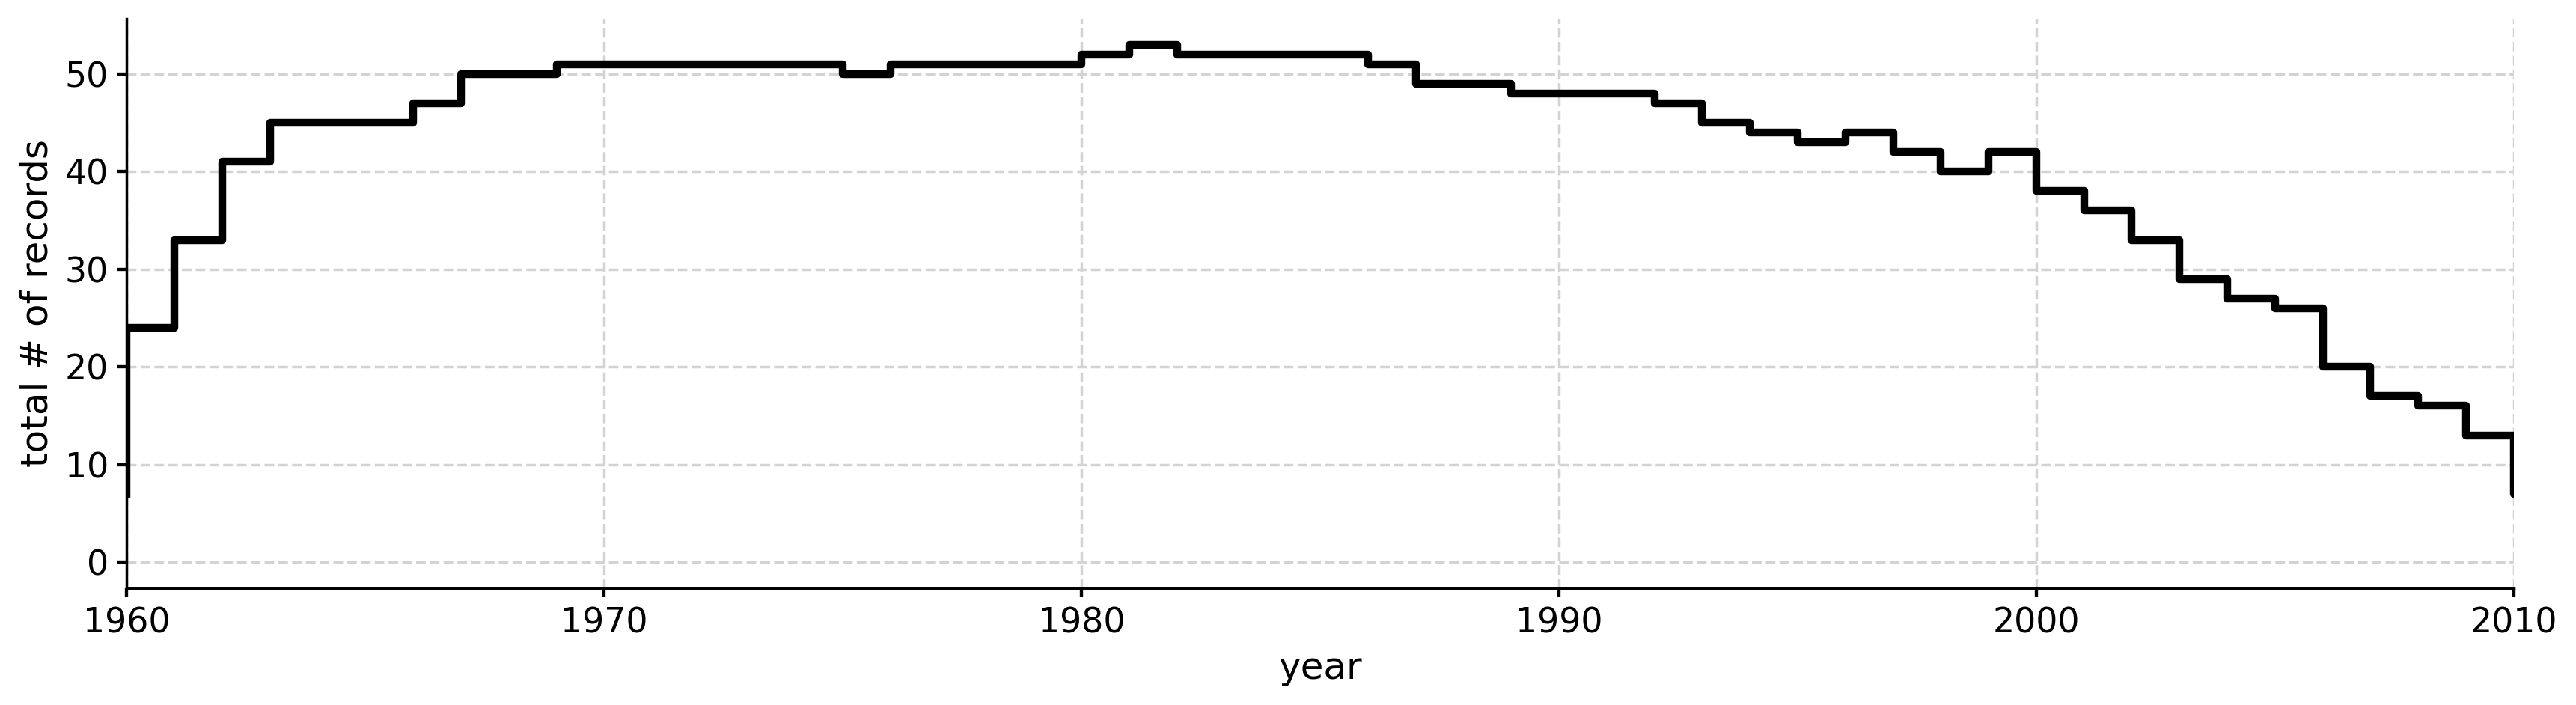

In [6]:
#%% plot the temporal coverage 
MinY     = [min([float(sy) for sy in yy])  for yy in filtered_df['year']] # find minimum year for each record
MaxY     = [max([float(sy) for sy in yy])  for yy in filtered_df['year']] # find maximum year for each record
MinMaxY  = np.array([MinY, MaxY]).T
years    = np.arange(min(MinY), max(MaxY)+1)

# generate array of coverage (how many records are available each year, in total)
coverage = np.zeros(years.shape[0])
for ii in range(len(filtered_df['year'])):
    coverage[(years>=MinY[ii])&(years<=MaxY[ii])] += 1

# plot results
fig = plt.figure(figsize=(14, 4), dpi=250)
ax = plt.gca()
plt.step(years, coverage, color='k', label='all records', lw=3)
plt.xlabel('year')
plt.ylabel('total # of records')

plt.xlim(min_year, max_year+4) # 1960 - 2010 range
ax.grid(True)
fig.tight_layout()

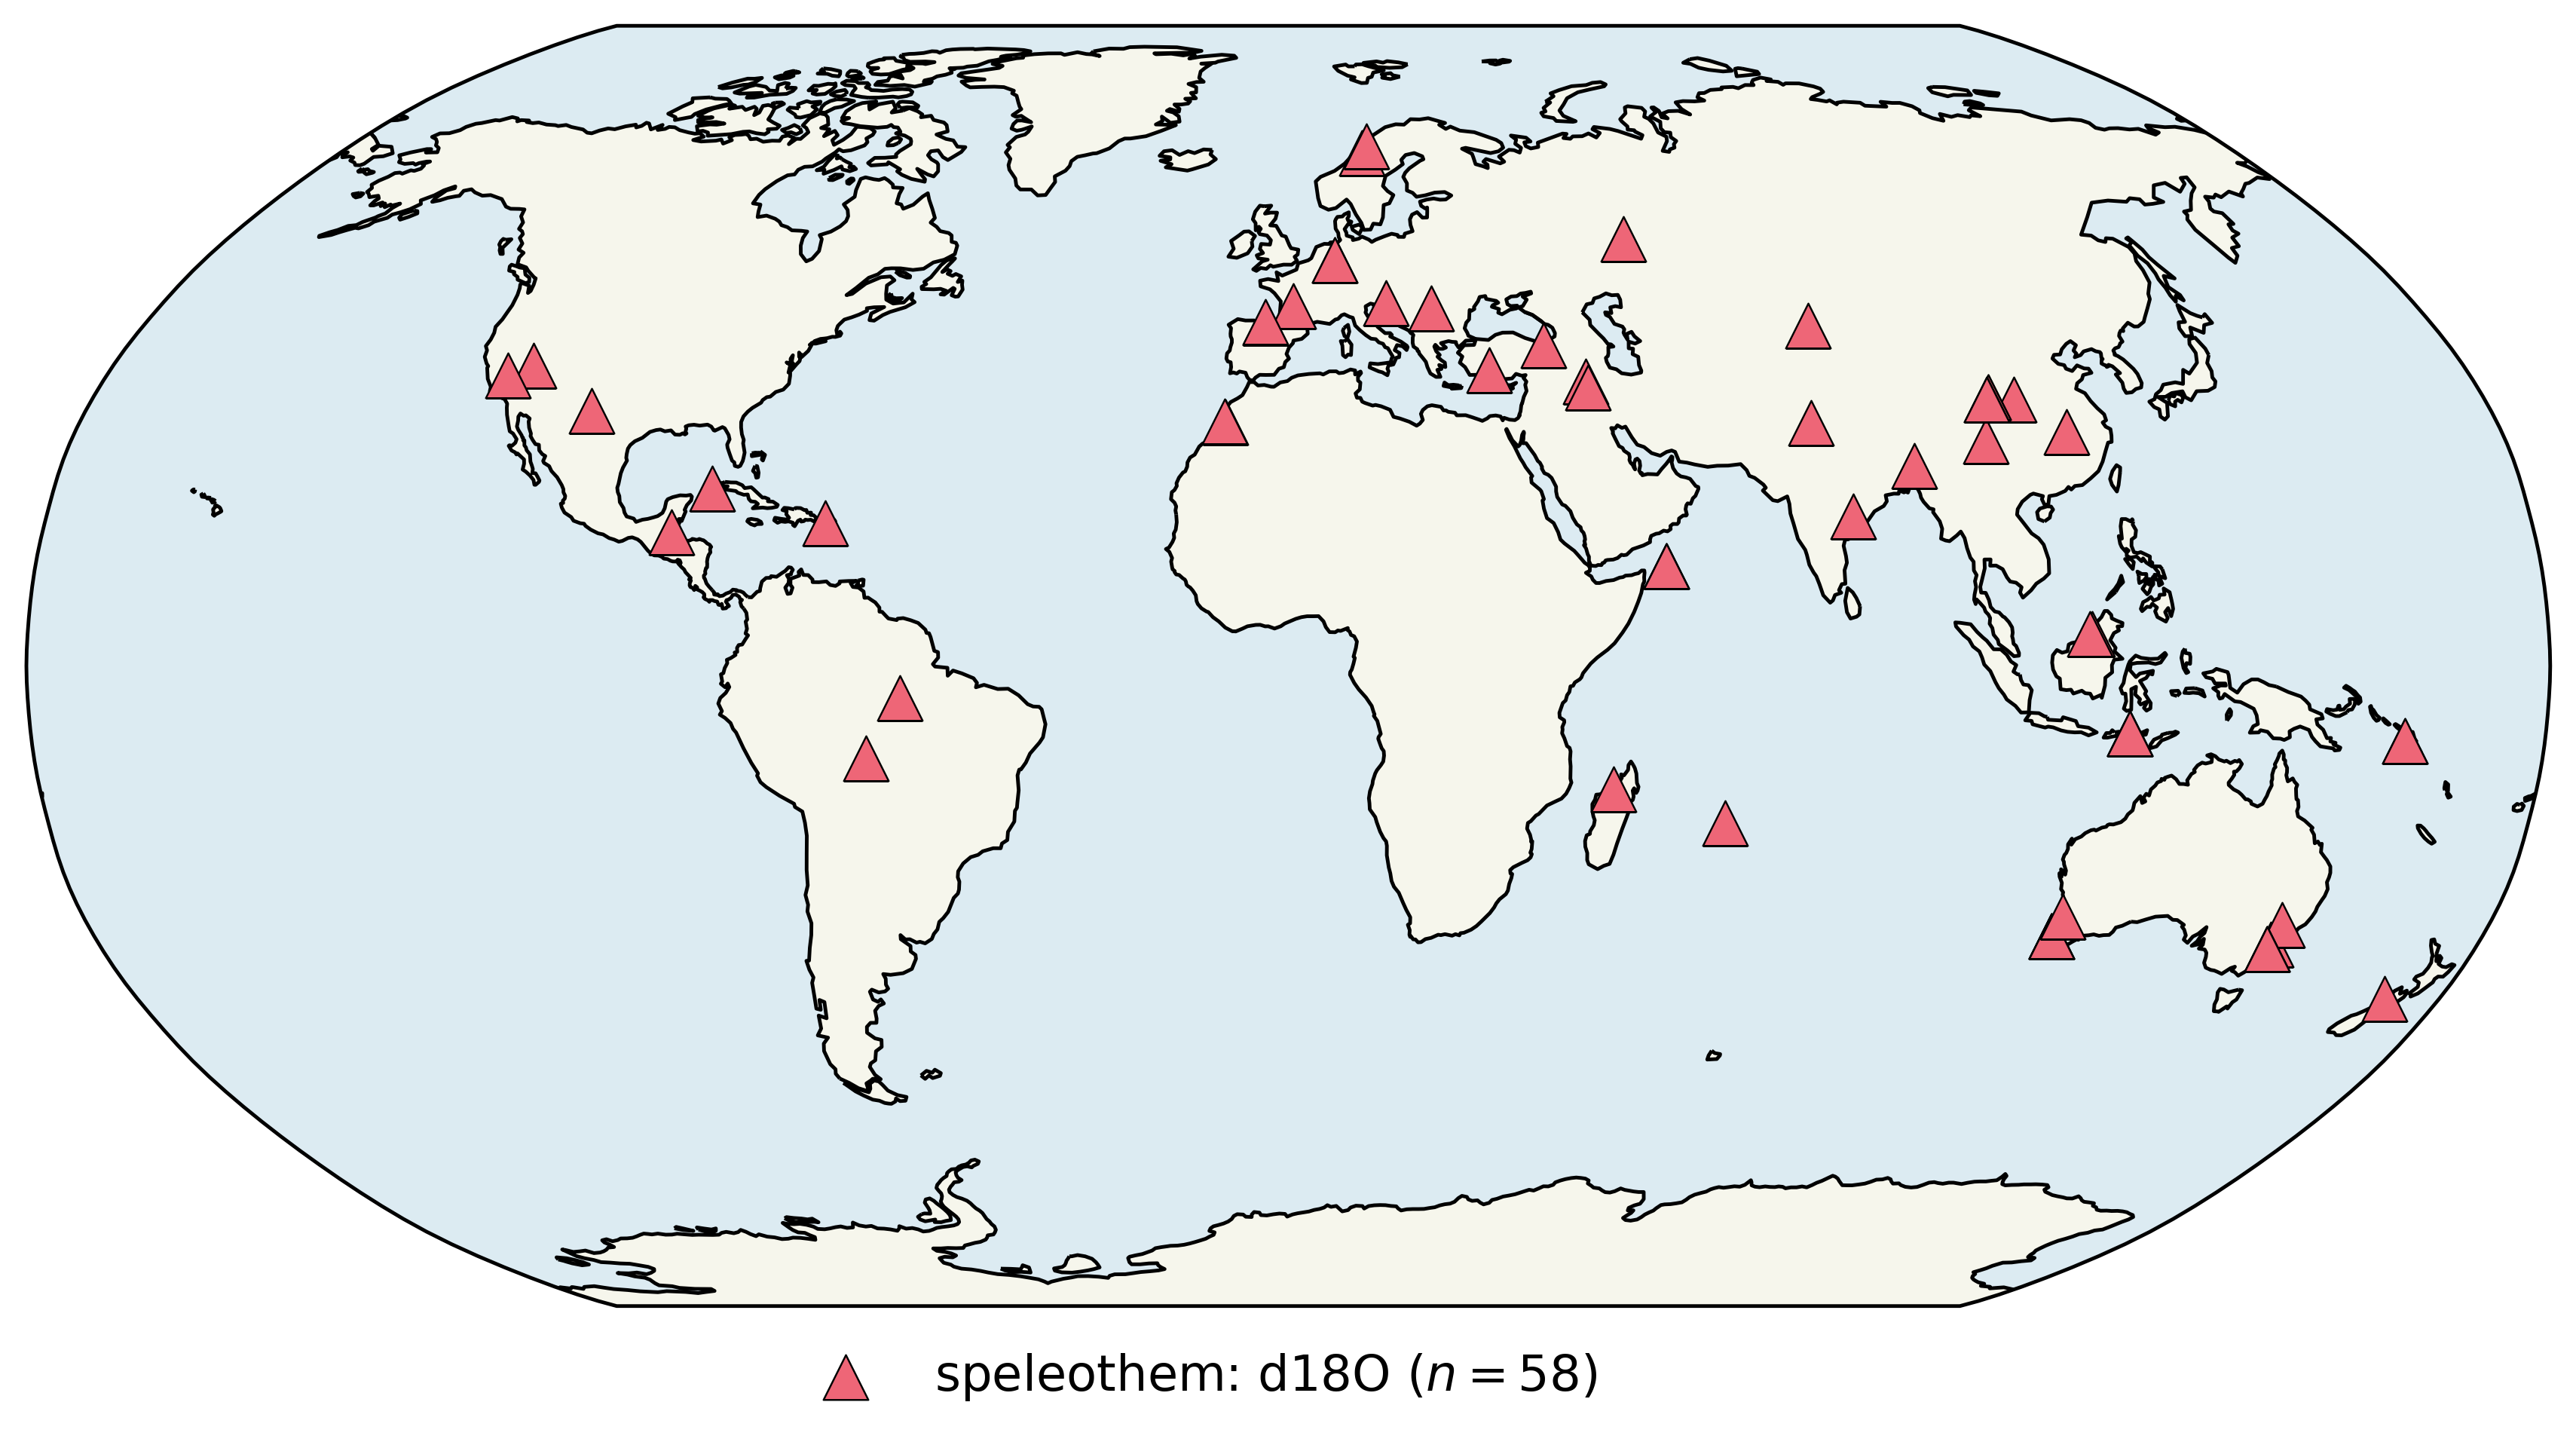

In [7]:
#%% plot the spatial distribution of all records
proxy_lats = filtered_df['geo_meanLat'].values
proxy_lons = filtered_df['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(13/1.3, 8/1.3), dpi=350)


ax = plt.subplot(111, projection=ccrs.Robinson()) # create axis with Robinson projection of globe
# ax.stock_img()

ax.add_feature(cfeature.LAND, alpha=0.5) # adds land features
ax.add_feature(cfeature.OCEAN, alpha=0.6, facecolor='#C5DEEA') # adds ocean features
ax.coastlines() # adds coastline features

ax.set_global()

pt, at = np.unique(filtered_df[['paleoData_proxy', 'archiveType']])
plt.scatter(proxy_lons, proxy_lats, 
            transform=ccrs.PlateCarree(), zorder=999,
            marker='^', color='#EE6677', s=150,
            label=at+': '+pt+' ($n=%d$)'%filtered_df['paleoData_proxy'].count(), 
            lw=.5, ec='k')
# plot the legend at the bottom, center
plt.legend(bbox_to_anchor=(0.64,0.0), ncol=2, fontsize=13.5, framealpha=0)
fig.tight_layout()
plt.savefig('figs/speleothem_modeling/speleo_d18Oc_obs_map.pdf', bbox_inches ='tight', transparent=None, #dpi=300, 
            format='pdf',
        metadata=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None) # bbox_inches=None
# raise Exception

In [8]:
# Choose relevant data for simulation comparison
df = filtered_df[['geo_meanLat', 'geo_meanLon', 'paleoData_values']]
df.loc[:,'paleoData_values'] = df.loc[:,'paleoData_values'].apply(np.average)
df.to_csv('speleothem_modeling_inputs/df_dod2k_speleo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   geo_meanLat       58 non-null     float32
 1   geo_meanLon       58 non-null     float32
 2   paleoData_values  58 non-null     object 
dtypes: float32(2), object(1)
memory usage: 1.0+ KB


## Load CRU TS

In [9]:
# Load temperature data, source: CRU TS 4.07 tmp
# if we use the cfr package to load the data, we can use its annualize function:
tmp = xr.open_dataset('./speleothem_modeling_inputs/cru_ts4.07.1901.2022.tmp.dat.nc.gz').load()
cruT_mon = tmp['tmp']
#Reduce this DataArray’s data by applying mean along some dimension(s).
cruT=cruT_mon.mean(dim='time')
print(cruT)

<xarray.DataArray 'tmp' (lat: 360, lon: 720)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(360, 720), dtype=float32)
Coordinates:
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 1kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75


## Load observed isotope data

In [10]:
path = os.curdir + '/speleothem_modeling_inputs/GlobalPrecip/d18o_MA.tif'
d18Op_da = rioxarray.open_rasterio(path)
if d18Op_da.sizes.get("band", 1) == 1:
    d18Op_da = d18Op_da.squeeze('band', drop=True)
d18Op_da = d18Op_da.rename({'x': 'lon', 'y': 'lat'})
d18Op_da = d18Op_da.where(np.abs(d18Op_da)<1e3)  # mask NaN regions
d18Op_da.attrs['units'] = 'permil'
d18Op_da.attrs['long_name'] = 'd18Op'
d18Op_da.name = 'd18Op'
#d18Op_da

## Join data

In [11]:
# create a dataframe to hold observed o18, T,o18p, pred o18c
pred_frame = pd.DataFrame()
pred_frame['geo_meanLon'] = filtered_df['geo_meanLon']
pred_frame['geo_meanLat'] = filtered_df['geo_meanLat']
pred_frame['d18Oc_vals'] = filtered_df['paleoData_values']
pred_frame['d18Op_vals'] = object
pred_frame['cruT_vals'] = object
pred_frame['d18Ocs_vals']= object #np.zeros(len['d18Op_vals'])#object #np.nan # object # np.nan(len(['d18Op_vals']))
print(len(pred_frame['d18Ocs_vals']))

# KF: Finding nearest param data to observed data
for idx, row in tqdm(pred_frame.iterrows(), total=len(pred_frame)):
    lon = row['geo_meanLon']
    lat = row['geo_meanLat']

    # temp
    nearest_cruT = f.find_nearest2d(cruT, lat, lon, lat_name='lat', lon_name='lon', new_dim='sites',r=6)
    if np.isnan(nearest_cruT).all():
        pred_frame.at[idx, 'cruT_vals'] = np.nan
    else:
        pred_frame.at[idx, 'cruT_vals'] = nearest_cruT.data
        #pred_frame.at[idx, 'cruT_vals'] = np.repeat(nearest_cruT.data,46)

    # d18Op
    nearest_o18p = f.find_nearest2d(d18Op_da, lat, lon, lat_name='lat', lon_name='lon', new_dim='sites', r=6)
    if np.isnan(nearest_o18p).all():
        pred_frame.at[idx, 'd18Op_vals'] = np.nan
    else:
        pred_frame.at[idx, 'd18Op_vals'] = nearest_o18p.data
        pred_frame.at[idx, 'd18Op_vals'] = np.repeat(nearest_o18p.data,46)
        
#pred_frame
# KF: Important to note that the simulated records use data collected from sites closest to, but not always at the same location as, the observed records
# KF: This data collection is done above. Methods for finding the nearest gridpoint to an observation can be found in the functions.py file, function find_nearest2d, written by Feng Zhu

58


100%|██████████| 58/58 [00:00<00:00, 593.68it/s]


In [12]:
# d18Oc averages 
d18Oc=[] # create an empty list
for idx in range(len(pred_frame)):
    #print(np.array(pred_frame['d18Oc_vals'][idx][0])) # this is what I want in my list.
    # populate the list
    d18Oc.append(pred_frame['d18Oc_vals'][idx][0])

d18Oc=pd.DataFrame(d18Oc).values # convert list to df
d18Oc=d18Oc.reshape(-1,1) # transpose list
#print(d18Oc)
# put these into the data frame in place of the raw values
pred_frame['d18Oc_vals'] = d18Oc

In [13]:
# sanity check - nonmissing data found?
pred_frame.isna().sum()
#pred_frame


geo_meanLon    0
geo_meanLat    0
d18Oc_vals     0
d18Op_vals     0
cruT_vals      0
d18Ocs_vals    0
dtype: int64

In [14]:
# Removing any rows where the simulation parameters break a 

# Modeling

## simulate d18Oc using PRYSM's sensor model 

now let's use cruT_vals and d18Op_vals to simulate o18c using PRYSM's sensor model for speleothem calcite


In [15]:
#PRYSM Speleothem Simulation Model Usage
#
#Speleothem Calcite [Sensor] Model
#   Converts environmental signals to d18O calcite/dripwater using
#   various models of karst aquifer recharge and calcification.
#
#   INPUTS:
#       dt        time step [years]                         (int or float, 1=1 year, 1./12. for months. etc.)
#       t        time axis [years]                          (numpy array, length n)
#       T        Average Annual Temperature     [K]         (numpy array, length n)
#       d18O    delta-18-O (precip or soil water) [permil]  (numpy array, length n)
#       NB: make sure these are precipitation weighted
#
#   MODEL PARAMETERS
#   ================
#       model:  aquifer recharge model. possible values 'Well-Mixed'[1,2] or 'Adv-Disp' [3]
#       tau0: mean transit time, [years]    (default = 0.5)
#       Pe: Peclet number [non-dimensional] (default = 1.0) ('Adv-Disp' only)
#
#    OUTPUTS:
#        d18Oc  cave dripwater delta-18-O
#        d18OK  delta-18-O of water after passage through karst
#        h      transit time distribution

In [16]:
# Simulation construction: using a series of 1960-2005 constant mean annual d18Op over time and a mean annual cruT to simulated d18Ocs
# because we use a constant o18p over time, the results are for equilibrium, well-mixed conditions over the time interval of study, 1960-2005
dt = 1
t = np.arange(min_year, max_year)
pred_frame['d18Ocs_vals'] = pred_frame.apply(lambda row: np.mean(psm.speleo.sensor.speleo_sensor(t,np.array(row['d18Op_vals']),np.array(row['cruT_vals']) + 273.15,dt,model='Well-Mixed',tau0=1)[0]),axis=1)
pred_frame

,geo_meanLon,geo_meanLat,d18Oc_vals,d18Op_vals,cruT_vals,d18Ocs_vals
0,-115.580002,37.889999,-10.800750,"[-12.7077, -12.7077, -12.7077, -12.7077, -12.7...",10.885996,-11.546744
1,14.000000,66.000000,-6.545692,"[-13.9568, -13.9568, -13.9568, -13.9568, -13.9...",1.1765707,-10.343688
2,91.866699,25.250000,-5.456000,"[-6.29485, -6.29485, -6.29485, -6.29485, -6.29...",20.941175,-7.427940
3,-89.108002,16.882999,-3.800000,"[-4.59672, -4.59672, -4.59672, -4.59672, -4.59...",23.995079,-6.384990
4,46.880001,-15.530000,-5.410159,"[-3.8563, -3.8563, -3.8563, -3.8563, -3.8563, ...",26.660091,-6.199871
5,120.430000,-8.530000,-6.260000,"[-7.88205, -7.88205, -7.88205, -7.88205, -7.88...",23.682524,-9.598678
6,-55.450001,-4.066700,-5.930000,"[-4.90709, -4.90709, -4.90709, -4.90709, -4.90...",26.539503,-7.223334
7,120.430000,-8.530000,-6.330000,"[-7.88205, -7.88205, -7.88205, -7.88205, -7.88...",23.682524,-9.598678
8,120.430000,-8.530000,-6.430000,"[-7.88205, -7.88205, -7.88205, -7.88205, -7.88...",23.682524,-9.598678
9,114.800003,4.030000,-9.152000,"[-8.97157, -8.97157, -8.97157, -8.97157, -8.97...",25.986683,-11.165239


In [17]:
# get column vectors of data for regression estimation
# 1. d18Ocs
d18Ocs=pred_frame.iloc[:,5].values
d18Ocs=d18Ocs.reshape(-1,1)
#print(d18Ocs)

In [18]:
# 2. d18Op 
d18Op=[] # create an empty list
for idx in range(len(pred_frame)):
    #print(np.array(pred_frame['d18Op_vals'][idx][0])) # this is what I want in my list.
    # populate the list
    d18Op.append(pred_frame['d18Op_vals'][idx][0])

d18Op=pd.DataFrame(d18Op).values # convert list to df
d18Op=d18Op.reshape(-1,1) # transpose list
#print(d18Op)

In [19]:
# 3. d18Oc
# is already created
#print(d18Oc)

In [20]:
# 4. Temp
Temp=pred_frame.iloc[:,4].values
Temp=Temp.reshape(-1,1)
#print(T)

[0.75392    0.09759962] [-3.65917211  4.617154  ]
R^2: 0.5406045913696289
RMSE: 2.6623922800830186
Slope: [0.45063245] p: 2.2600966172126036e-05 t: 4.617154000897069 Standard Error: 0.09759961501765571 Variance 0.009525684851594605
Intercept: [-2.758723] p: 0.0005543178530238446 t: -3.6591721113046405 Standard Error: 0.7539199951898393 Variance 0.5683953591470473


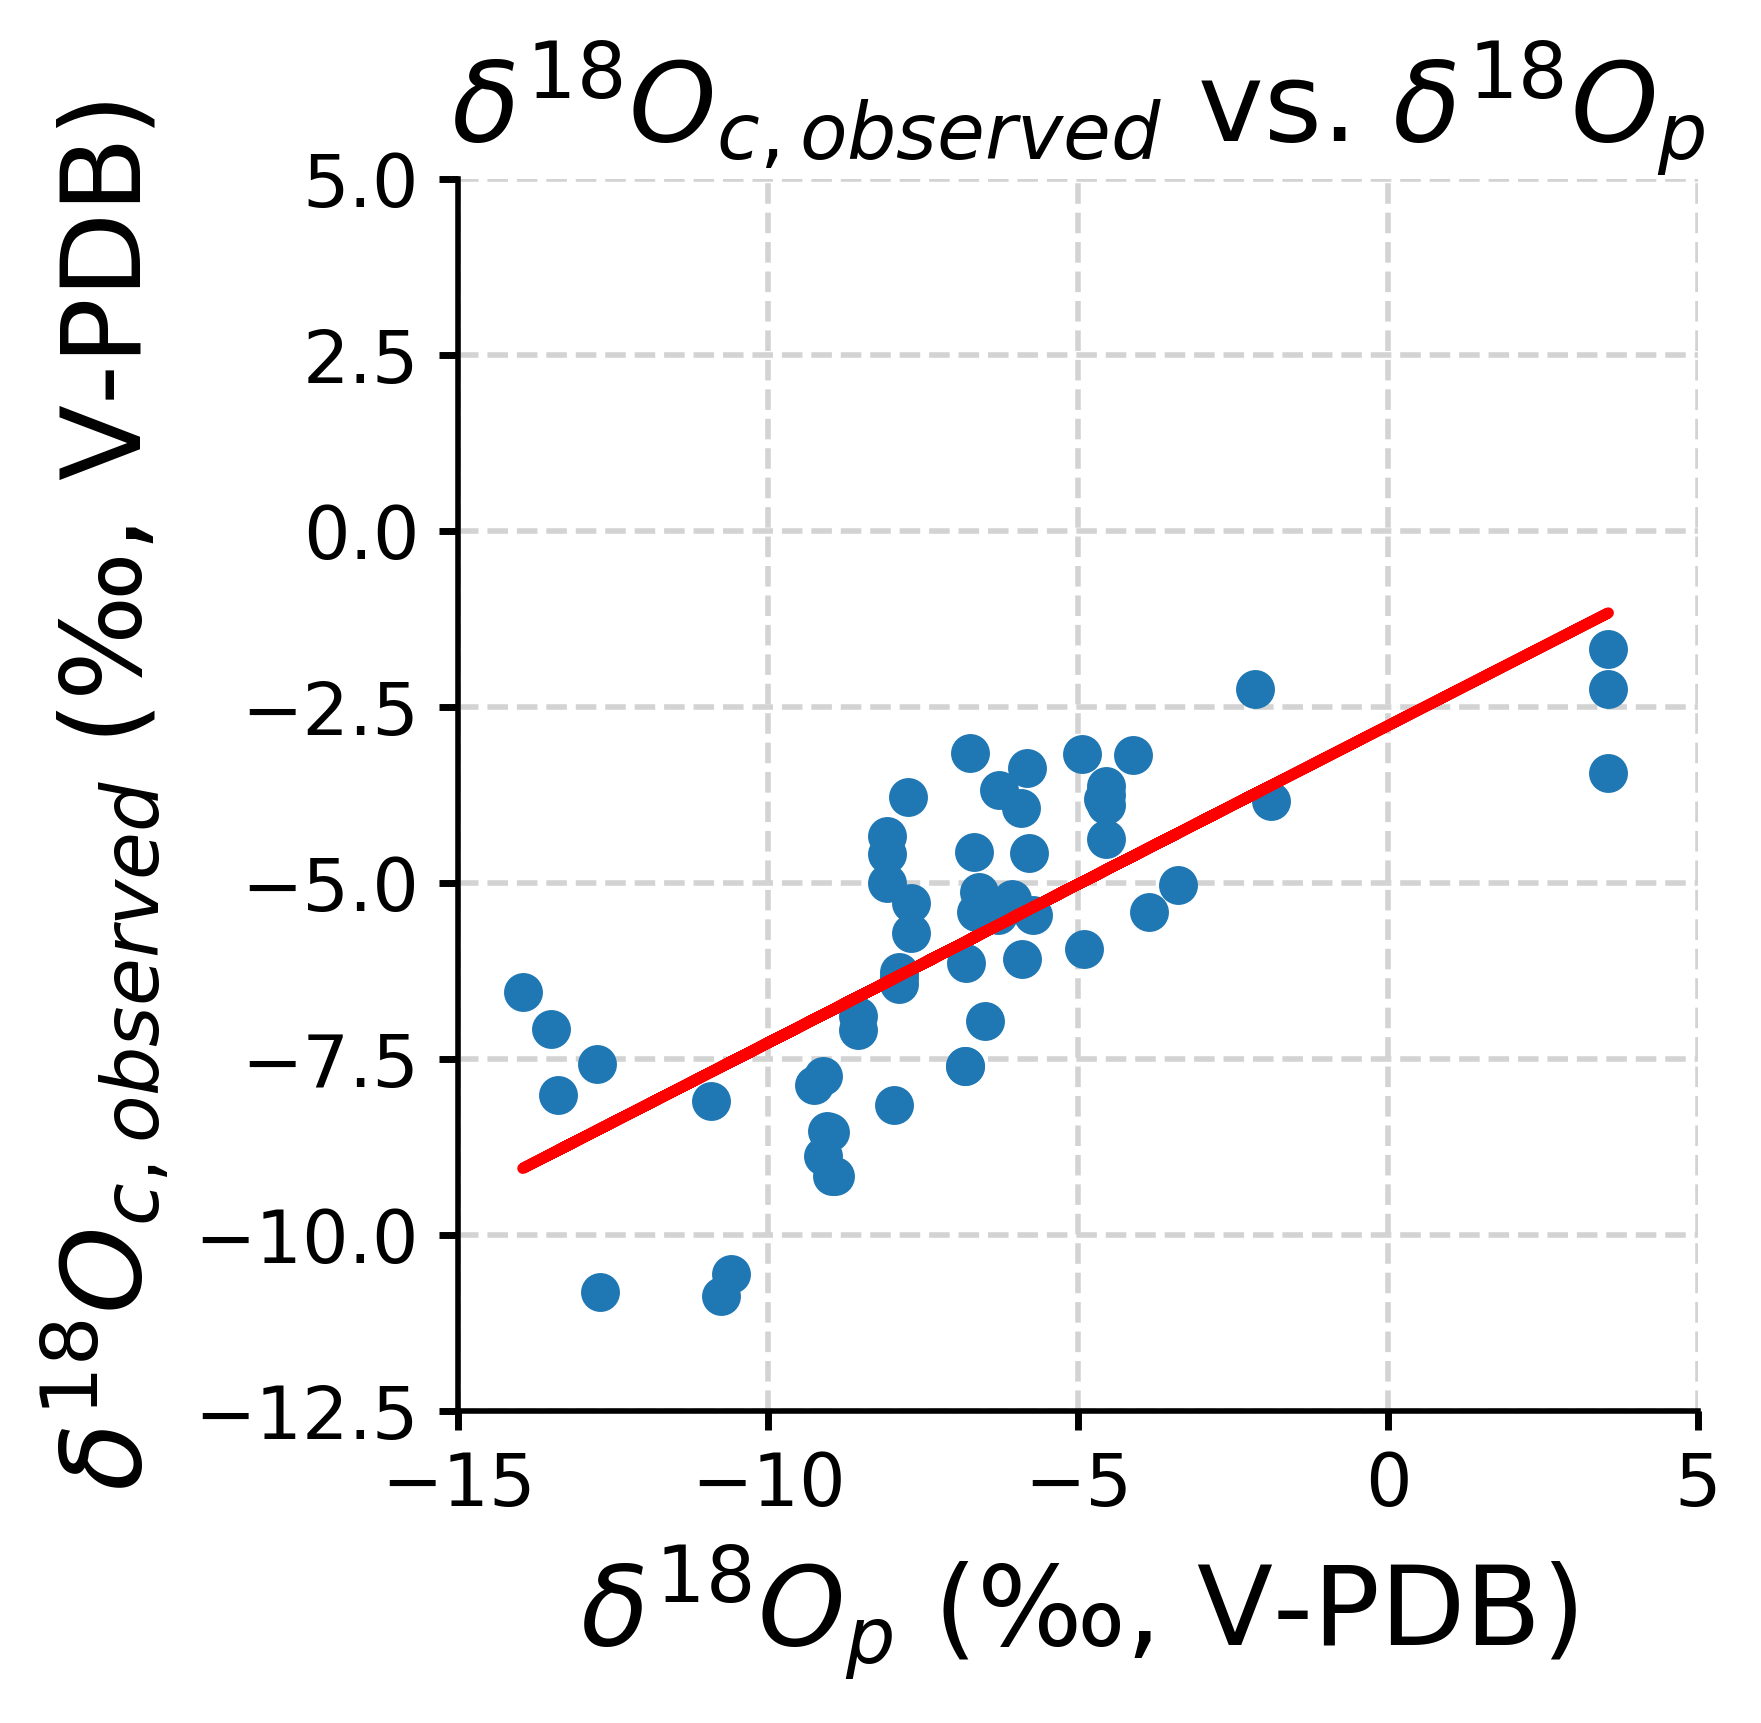

In [21]:
# 1. get regression of o18c on o18p 
# Using scikit and also for p_values, see: https://www.datacourses.com/find-p-value-significance-in-scikit-learn-3810/
model1 = sklearn.linear_model.LinearRegression()
model1.fit(d18Op, d18Oc)
d18Ochat = model1.predict(d18Op)
r2_d18Op_d18Oc = model1.score(d18Op, d18Oc)
mse_d18Oc = sklearn.metrics.mean_squared_error(d18Op, d18Oc)
#print(d18Ochat)
# P values and other statistical measures
params1 = np.append(model1.intercept_,model1.coef_)
X = pd.DataFrame({"Constant":np.ones(len(d18Op))}).join(pd.DataFrame(d18Op))
var1_b = mse_d18Oc*(np.linalg.inv(np.dot(X.T,X)).diagonal())
sd1_b = np.sqrt(var1_b)
ts1_b = params1/ sd1_b
print(sd1_b, ts1_b)
p_values1 =[2*(1-scipy.stats.t.cdf(np.abs(i),(len(X)-len(d18Op[0])))) for i in ts1_b]

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(4,4), dpi=400)
plt.plot(d18Op,d18Oc,'o',d18Op,d18Ochat,'r-')

plt.xlabel(r"$\delta^{18}O_{p}$ (" f"\u2030, V-PDB)", fontsize=20) # MNE cleaned up the plot labeling
plt.ylabel(r"$\delta^{18}O_{c,observed}$ (" f"\u2030, V-PDB)", fontsize=20)
plt.xlim([-15, 5])
plt.ylim([-12.5, 5])
plt.title(r"$\delta^{18}O_{c,observed}$ vs. $\delta^{18}O_{p}$", fontsize=20)

plt.grid(True)
#plt.axis('equal') # MNE added
plt.show
print("R^2:", r2_d18Op_d18Oc)
print("RMSE:", np.sqrt(mse_d18Oc))
print("Slope:", model1.coef_[0], "p:", p_values1[1], "t:", ts1_b[1], "Standard Error:", sd1_b[1], "Variance", var1_b[1])
print("Intercept:", model1.intercept_, "p:", p_values1[0], "t:", ts1_b[0], "Standard Error:", sd1_b[0], "Variance", var1_b[0])
plt.savefig('figs/speleothem_modeling/speleo_d18Op_d18Oc_scatter.pdf', transparent=None, dpi=300, format='pdf',
        metadata=None, bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None)

[6.92215614 0.39375664] [-1.05756206  0.23690261]
R^2: 0.10486792593075256
RMSE: 22.85377927282009
Slope: [0.09328198] p: 0.8135816962511353 t: 0.2369026141949368 Standard Error: 0.3937566383260926 Variance 0.1550442902258653
Intercept: [-7.32060973] p: 0.29471665065094665 t: -1.0575620628826996 Standard Error: 6.9221561388464625 Variance 47.91624561056977


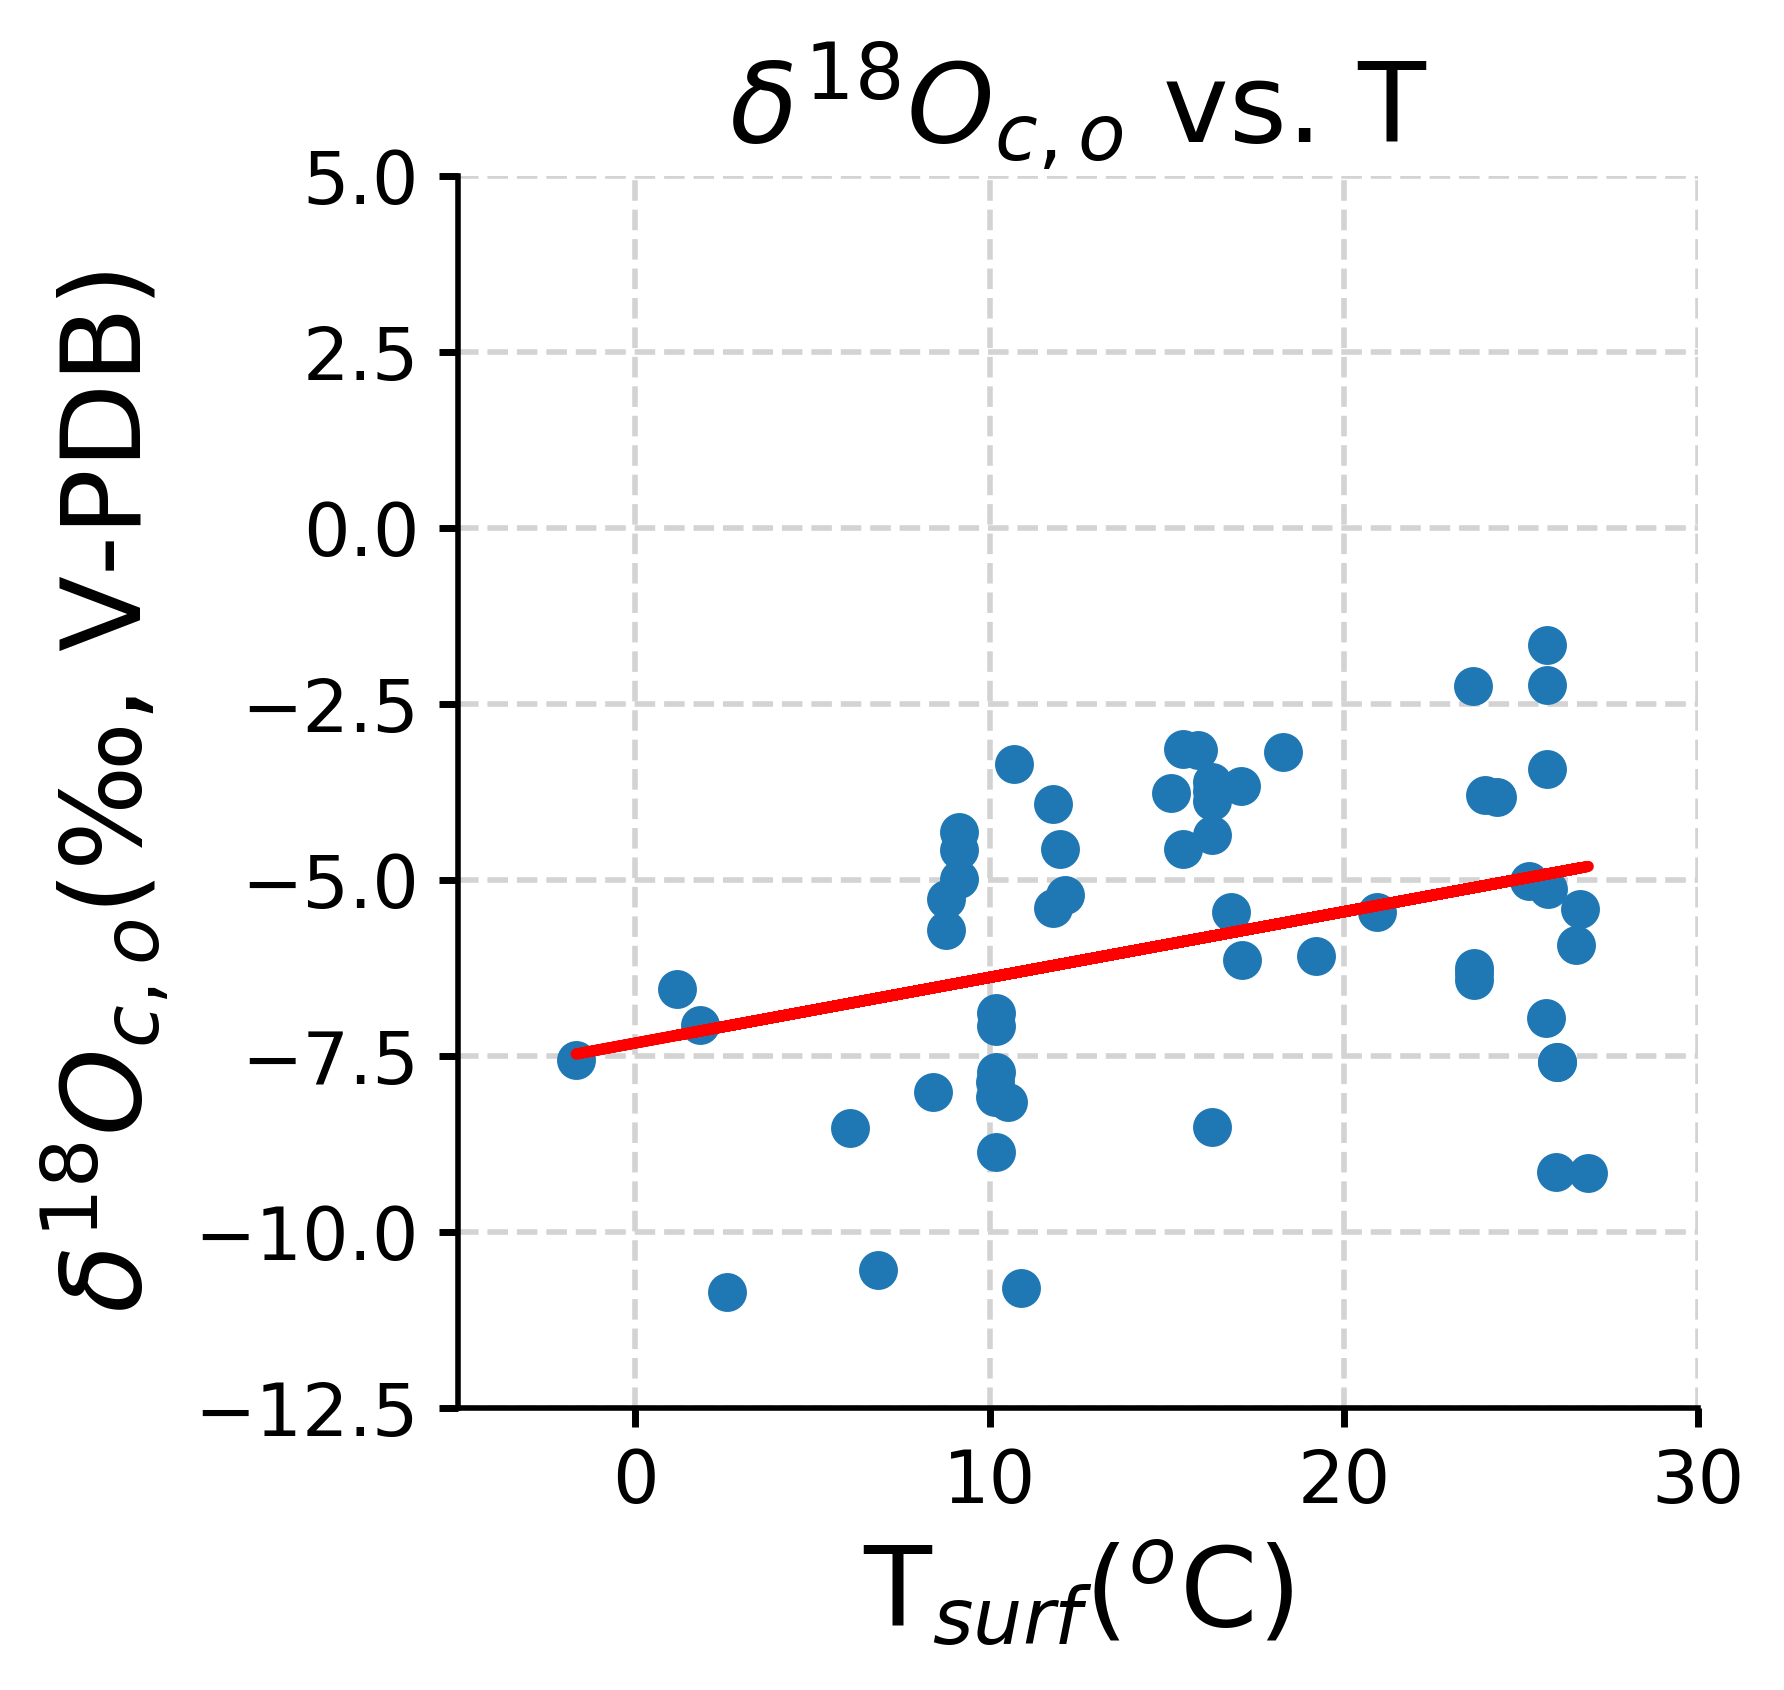

In [22]:
# 2. get regression of o18c on T 
model2 = sklearn.linear_model.LinearRegression()
model2.fit(Temp, d18Oc)
d18OcThat = model2.predict(Temp)
r2_Temp_d18Oc = model2.score(Temp, d18Oc)
mse_d18OcT = sklearn.metrics.mean_squared_error(Temp, d18Oc)
# P values and other statistical measures
params2 = np.append(model2.intercept_,model2.coef_)
X2 = pd.DataFrame({"Constant":np.ones(len(Temp))}).join(pd.DataFrame(Temp)).astype(float)
var2_b = mse_d18OcT*(np.linalg.inv(np.dot(X2.T,X2)).diagonal())
sd2_b = np.sqrt(var2_b)
ts2_b = params2/ sd2_b
print(sd2_b, ts2_b)
p2_values =[2*(1-scipy.stats.t.cdf(np.abs(i),(len(X)-len(Temp[0])))) for i in ts2_b]
# Referencing https://www.datacourses.com/find-p-value-significance-in-scikit-learn-3810/

#Plot scatter and regression line
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(4,4), dpi=400)
plt.plot(Temp,d18Oc,'o',Temp,d18OcThat,'r-')
plt.ylabel(r"$\delta^{18}O_{c,o}$" f"(\u2030, V-PDB)",fontsize=20) # MNE cleaned up the plot labeling
plt.xlabel(r"T$_{surf}$($^{o}$C)", fontsize=20)
plt.title(r"$\delta^{18}O_{c,o}$ vs. T", fontsize=20)
plt.ylim([-12.5, 5])
plt.xlim([-5, 30])
plt.show
plt.grid(True)

# here are regression statistics
print("R^2:", r2_Temp_d18Oc)
print("RMSE:", np.sqrt(mse_d18OcT))
print("Slope:", model2.coef_[0], "p:", p2_values[1], "t:", ts2_b[1], "Standard Error:", sd2_b[1], "Variance", var2_b[1])
print("Intercept:", model2.intercept_, "p:", p2_values[0], "t:", ts2_b[0], "Standard Error:", sd2_b[0], "Variance", var2_b[0])
plt.savefig('figs/speleothem_modeling/speleo_d18Oc_T_scatter.pdf', transparent=None, dpi=300, format='pdf',
        metadata=None, bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None)

[0.76891845 0.12319171] [-1.73325435  7.55917068]
R^2: 0.5548699041094567
RMSE: 2.0596243566162524
Slope: [0.93122715] p: 3.720646013505302e-10 t: 7.559170681675389 Standard Error: 0.12319170803175979 Variance 0.015176196927782349
Intercept: [-1.3327312] p: 0.08845754765162694 t: -1.7332543501861934 Standard Error: 0.7689184491618756 Variance 0.5912355814615039


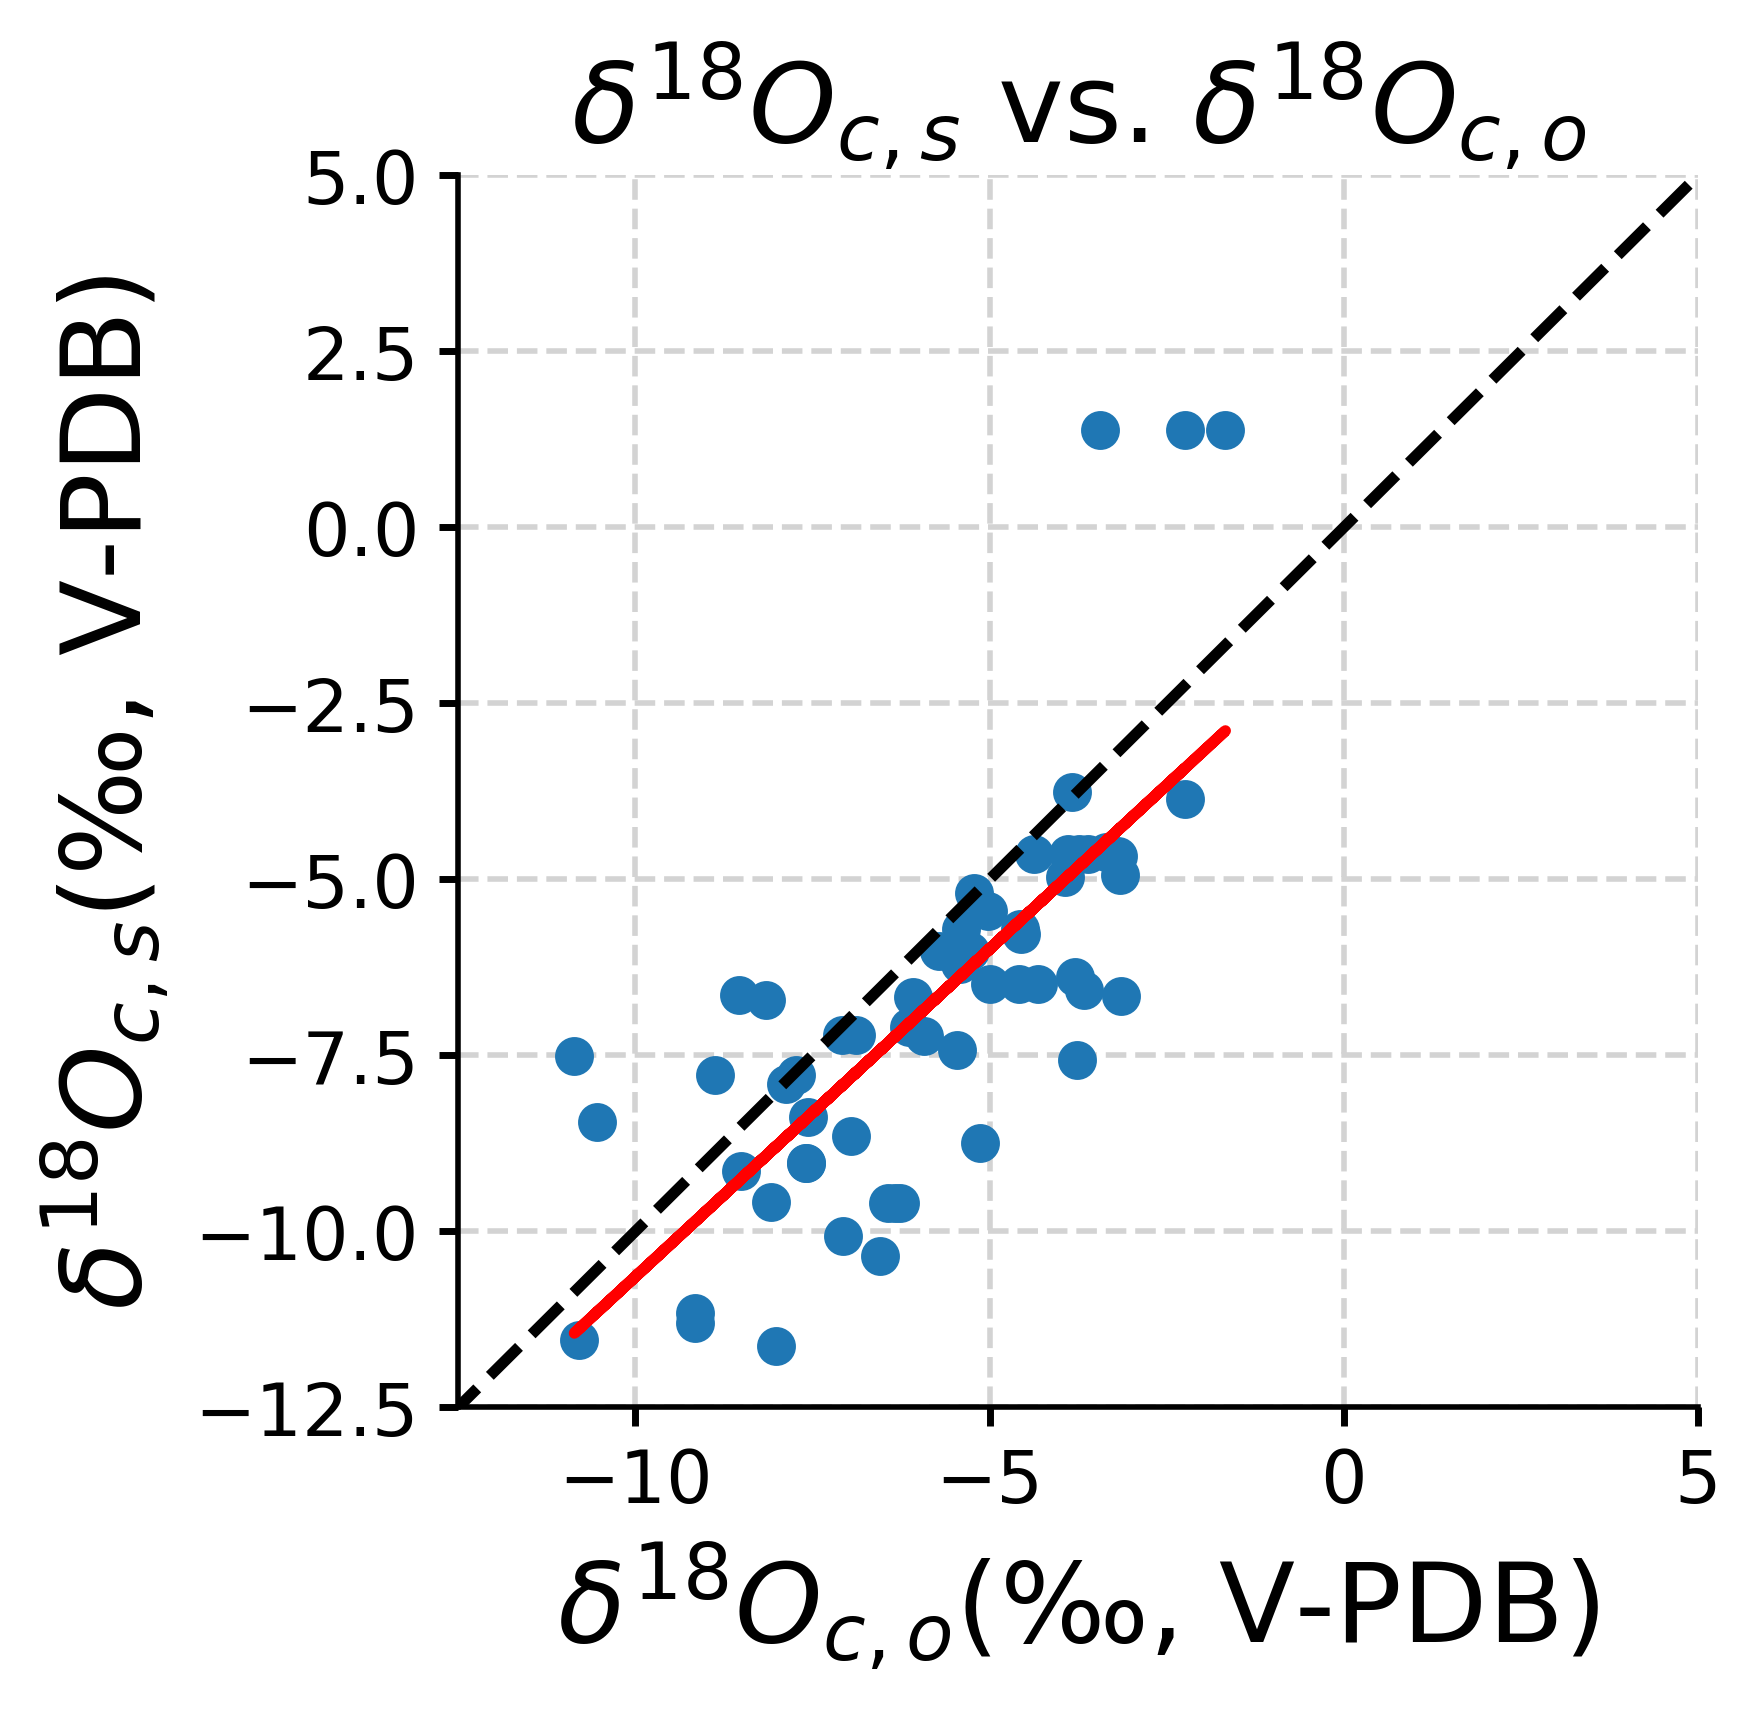

In [23]:
# 3. get regression of o18cs on o18c 
model3 = sklearn.linear_model.LinearRegression()
model3.fit(d18Oc, d18Ocs)
d18Ocshat = model3.predict(d18Oc)
r2_d18Oc_d18Ocs = model3.score(d18Oc, d18Ocs)
mse_d18Ocs = sklearn.metrics.mean_squared_error(d18Oc, d18Ocs)
#print(d18Ocshat)
# P values and other statistical measures
params3 = np.append(model3.intercept_,model3.coef_)
X3 = pd.DataFrame({"Constant":np.ones(len(d18Oc))}).join(pd.DataFrame(d18Oc))
var3_b = mse_d18Ocs*(np.linalg.inv(np.dot(X3.T,X3)).diagonal())
sd3_b = np.sqrt(var3_b)
ts3_b = params3/ sd3_b
print(sd3_b, ts3_b)
p_values3 =[2*(1-scipy.stats.t.cdf(np.abs(i),(len(X3)-len(d18Oc[0])))) for i in ts3_b]
# Referencing https://www.datacourses.com/find-p-value-significance-in-scikit-learn-3810/

#Plot line of slope 1 with same intercept for comparison
plt.rcParams.update({'font.size': 20})
d18Ocs_line = np.linspace(-15,5,100) # MNE adjusted 1:1 line range
d18Oc_line = d18Ocs_line 
#plt.plot(d18Op_line,d18Oc_line, 'r', label = "1:1")
#plt.legend(loc="upper left")
fig = plt.figure(figsize=(4,4), dpi=400)
plt.plot(d18Oc,d18Ocs,'o',d18Oc,d18Ocshat,'r-',d18Oc_line,d18Oc_line,'k--')

plt.xlabel(r"$\delta^{18}O_{c,o}$" f"(\u2030, V-PDB)", fontsize=20) # MNE cleaned up the plot labeling
plt.ylabel(r"$\delta^{18}O_{c,s}$" f"(\u2030, V-PDB)", fontsize=20)
plt.title(r"$\delta^{18}O_{c,s}$ vs. $\delta^{18}O_{c,o}$", fontsize=20)

plt.xlim([-12.5, 5])
plt.ylim([-12.5, 5])
#plt.axis('equal') # MNE added
plt.show
plt.grid(True)
print("R^2:", r2_d18Oc_d18Ocs)
print("RMSE:", np.sqrt(mse_d18Ocs))
print("Slope:", model3.coef_[0], "p:", p_values3[1], "t:", ts3_b[1], "Standard Error:", sd3_b[1], "Variance", var3_b[1])
print("Intercept:", model3.intercept_, "p:", p_values3[0], "t:", ts3_b[0], "Standard Error:", sd3_b[0], "Variance", var3_b[0])
#plt.savefig('figs/speleothem_modeling/speleo_d18Ocs_d18Oc_scatter.pdf', transparent=None, dpi=300, format='pdf',
#        metadata=None, bbox_inches='tight', pad_inches=0.1,
#        facecolor='auto', edgecolor='auto', backend=None)

In [24]:
# are the 1:1 and o18cs on d18Oc slopes significantly different?
o=model3.coef_[0]
print('slope of regression of o18cs vs o18co: ', np.round(model3.coef_[0],2))
print('standard error of regression of o18cs vs o18co: ', np.round(sd3_b[1],2))
t_slope_1=(1-model3.coef_[0])/np.sqrt(sd3_b[1]**2)
print('t value for slope of o18cs vs o18co vs 1:1 slope: ', np.round(t_slope_1,2))
p_value_slope =[2*(1-scipy.stats.t.cdf(t_slope_1,(len(X3)-2)))]
print('p value: ', np.round(p_value_slope,8))
# slope is not significantly different from 1:1 line
# how about the mean difference?
mean_diff=(np.mean(d18Ocs)-np.mean(d18Oc))
print('mean difference (d18Oc - d18Ocs): ', np.round(mean_diff,2))
se_mean_diff=np.sqrt(np.mean(np.std(d18Ocs)**2/len(d18Ocs)+np.std(d18Oc)**2/len(d18Oc)))
print('standard error of the mean difference: ', np.round(se_mean_diff,2))
t_mean_diff=(np.mean(d18Oc)-np.mean(d18Ocs))/np.sqrt(np.mean(np.std(d18Ocs)**2/len(d18Ocs)+np.std(d18Oc)**2/len(d18Oc)))
print('t_mean_diff: ', np.round(t_mean_diff,2))
p_value_mean_diff=[2*(1-scipy.stats.t.cdf(t_mean_diff,(len(X)-2)))]
print('p value for difference of means: ', np.round(p_value_mean_diff,4))
# simulated d18Oc is significantly lower than observed d18Oc
# this difference is about 
frac_diff=np.abs(mean_diff)/(np.max(d18Oc)-np.min(d18Oc))
print('percent bias : ', np.round(frac_diff*100,1))

slope of regression of o18cs vs o18co:  [0.93]
standard error of regression of o18cs vs o18co:  0.12
t value for slope of o18cs vs o18co vs 1:1 slope:  [0.56]
p value:  [[0.57889297]]
mean difference (d18Oc - d18Ocs):  -0.93
standard error of the mean difference:  0.46
t_mean_diff:  2.02
p value for difference of means:  [0.0485]
percent bias :  10.1


In [25]:
# clean up the dataframe to list only the mean value of o18p in the corresponding column of the data 
pred_frame['d18Op_vals']=d18Op
pred_frame

,geo_meanLon,geo_meanLat,d18Oc_vals,d18Op_vals,cruT_vals,d18Ocs_vals
0,-115.580002,37.889999,-10.800750,-12.70770,10.885996,-11.546744
1,14.000000,66.000000,-6.545692,-13.95680,1.1765707,-10.343688
2,91.866699,25.250000,-5.456000,-6.29485,20.941175,-7.427940
3,-89.108002,16.882999,-3.800000,-4.59672,23.995079,-6.384990
4,46.880001,-15.530000,-5.410159,-3.85630,26.660091,-6.199871
5,120.430000,-8.530000,-6.260000,-7.88205,23.682524,-9.598678
6,-55.450001,-4.066700,-5.930000,-4.90709,26.539503,-7.223334
7,120.430000,-8.530000,-6.330000,-7.88205,23.682524,-9.598678
8,120.430000,-8.530000,-6.430000,-7.88205,23.682524,-9.598678
9,114.800003,4.030000,-9.152000,-8.97157,25.986683,-11.165239


### Bibliography
Bowen, G.J., Wassenaar, L.I., Hobson, K.A. (2005). Global application of stable hydrogen and oxygen isotopes to wildlife forensics. Oecologia 143, 337–348. https://doi.org/10.1007/s00442-004-1813-y.  Data retrieved from:  https://wateriso.utah.edu/waterisotopes/media/ArcGrids/GlobalPrecip.zip, last accessed 2025/08/03.  <br> <br>
Dee, S., J. Emile-Geay, M. N. Evans, A. Allam, E. J. Steig, and D. M. Thompson (2015). PRYSM: An open-source framework for PRoxY System Modeling, with applications to oxygen-isotope systems. J. Adv. Model. Earth Syst., 7, 1220–1247. https://doi.org/10.1002/2015MS000447. <br> <br>
Harris, I., Osborn, T.J., Jones, P. et al. (2020). Version 4 of the CRU TS monthly high-resolution gridded multivariate climate dataset. Sci Data 7, 109. https://doi.org/10.1038/s41597-020-0453-3.  Data retrieved from:  https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/cruts.2304141047.v4.07/tmp/cru_ts4.07.1901.2022.tmp.dat.nc.gz, last accessed 2025/08/03. <br> <br>
Hu, J., J. Emile-Geay, J. Partin (2017). Correlation-based interpretations of paleoclimate data – where statistics meet past climates, Earth and Planetary Science Letters, 459, 362-371. https://doi.org/10.1016/j.epsl.2016.11.048.